In [2]:
# this demo generates a waveform
# then fits several networks separately on scaled versions of the
# waveform to show the effect.

In [3]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

import numpy as np

import lal
import lalsimulation as lalsim

# from scrinet.interfaces import lalutils, rotations 
from wispy import lalutils, rotations 


from tensorflow.keras.utils import get_custom_objects
import pugna.activations
import pugna.layers
import pugna.models
import pugna.callbacks
import wispy.mscalev2
import wispy.mscalev3
import wispy.mscalev4
import wispy.mscalev5
import wispy.model_utils
import wispy.callbacks
import wispy.utils
import wispy.logger
import wispy.resnet
import wispy
import subprocess
import datetime
import argparse
import sys
import os
import numpy as np
import tqdm
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

In [50]:
get_custom_objects().update({'s2relu': pugna.activations.s2relu})


In [4]:
# generate waveforms

1.1785016498623269 1.2246467991473532e-16 -0.0


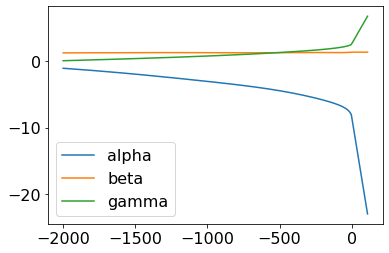

In [5]:
S1x=0.99
S2x=0.99

# S1x=0.
# S2x=0.

params = lalutils.gen_td_modes_wf_params(
    m1=100,
    m2=10,
    approximant=lalsim.SEOBNRv4P,
    S1x=S1x,
    S1y=0.,
    S2x=S2x,
    S2y=0.,
    f_min=12,
    f_ref=12,
    phiRef=1.2)

times, hlms = lalutils.gen_td_modes_wf(params, eob_all_ell_2_modes=True, modes=[[2,2],[2,1]], t_min=-2000, t_max=110)

thetaJN, alpha0, phi_aligned = rotations.compute_L_to_J_angles(
    mass1=params['m1'], mass2=params['m2'], f_ref=params['f_min'], inc=0, phiref=params['phiRef'],
    spin1x=params['S1x'], spin1y=params['S1y'], spin1z=params['S1z'],
    spin2x=params['S2x'], spin2y=params['S2y'], spin2z=params['S2z'])
print(thetaJN, alpha0, phi_aligned)

wr = rotations.WaveformRotations(
    times=times,
    hlms=hlms, 
    frame='inertial-L',
    alpha0=alpha0,
    thetaJN=thetaJN,
    phi0=phi_aligned) 

wr.from_inertial_frame_to_coprecessing_frame()

plt.figure()
plt.plot(wr.times, wr.alpha, label='alpha')
plt.plot(wr.times, wr.beta, label='beta')
plt.plot(wr.times, wr.gamma, label='gamma')
plt.legend()

wr.from_coprecessing_frame_to_inertial_frame()

In [6]:
# preprocess waveforms

In [168]:
# scale times
# times_scaler = MinMaxScaler(feature_range=(-1,0))
# times_scaler = MinMaxScaler(feature_range=(-0.5, 0.5))
times_scaler = MinMaxScaler(feature_range=(-0.1, 0.1))
# times_scaler = MinMaxScaler(feature_range=(-0.1,0))
X_train_base = times_scaler.fit_transform(times[:,np.newaxis])

In [169]:
X_train_base

array([[-0.1       ],
       [-0.09995728],
       [-0.09991457],
       ...,
       [ 0.09991457],
       [ 0.09995728],
       [ 0.1       ]])

In [170]:
scale_22 = np.abs(wr.hlms[(2,2)]).max()
print(scale_22)
# y_train = np.column_stack(
#     (wr.hlms[(2,2)].real/scale_22,wr.hlms[(2,2)].imag/scale_22)
# )

y_train = np.abs(wr.hlms[(2,2)])/scale_22
y_train = y_train[:, np.newaxis]

0.10620956808412164


In [171]:
y_train

array([[0.19542968],
       [0.19161033],
       [0.18772867],
       ...,
       [0.00097104],
       [0.00093576],
       [0.00089894]])

In [172]:
X_train_base.shape

(4683, 1)

In [173]:
y_train.shape

(4683, 1)

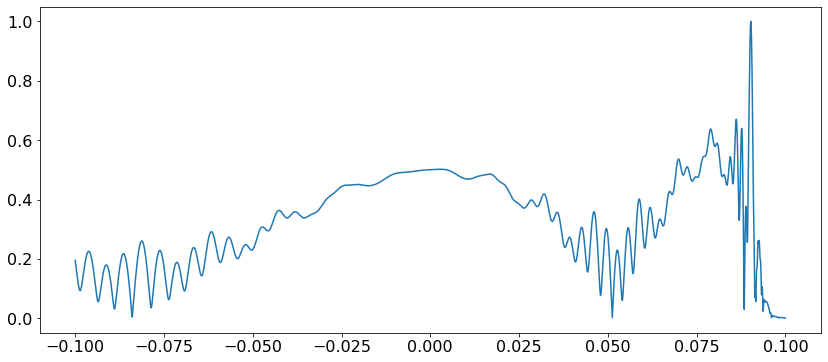

In [174]:
plt.figure(figsize=(14, 6))
plt.plot(X_train_base[:,0], y_train[:,0])

In [175]:
def build_model(units=32, activation_1='relu', activation='relu', lr=1e-3):
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,)),
        tf.keras.layers.Dense(units, activation_1),
        tf.keras.layers.Dense(units, activation),
        tf.keras.layers.Dense(units, activation),
        tf.keras.layers.Dense(1, activation='linear'),
    ])
    
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=lr))
    
    return model

In [189]:
%%time
scales = [1, 10, 50]
# scales = [10, 20]

epochs=2000
# batch_size=len(y_train)//4
# batch_size=len(y_train)//10
batch_size=128

print(f"batch_size: {batch_size}")


X_train = {}

models = {}
histories = {}

yhats = {}

for i, scale in enumerate(scales):
    print(f"{i+1}/{len(scales)}")
    X_train[scale] = X_train_base * scale
    
    m = build_model(units=128, activation_1='s2relu', activation='s2relu', lr=1e-4)
    h = m.fit(X_train[scale], y_train, epochs=epochs, verbose=0, batch_size=batch_size)
    
    yhats[scale] = m.predict(X_train[scale])
    
    models[scale]=m
    histories[scale]=h

batch_size: 128
1/3
2/3
3/3
CPU times: user 9min 10s, sys: 2min 52s, total: 12min 2s
Wall time: 4min 2s


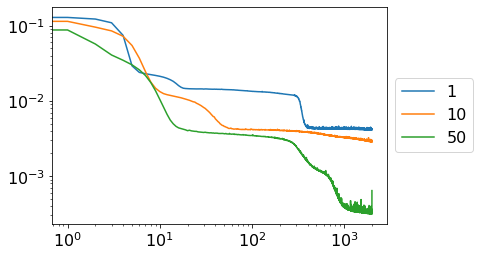

In [190]:
plt.figure()
for k in histories.keys():
    plt.plot(histories[k].history['loss'], label=k)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')
plt.xscale('log')

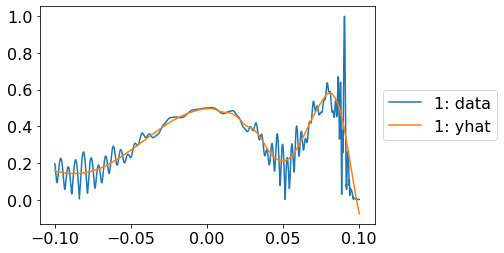

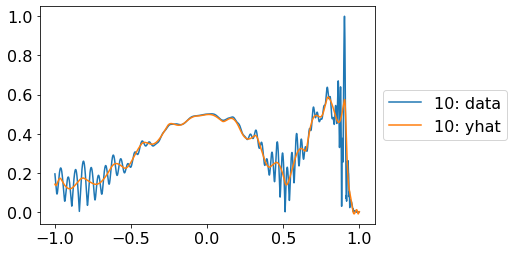

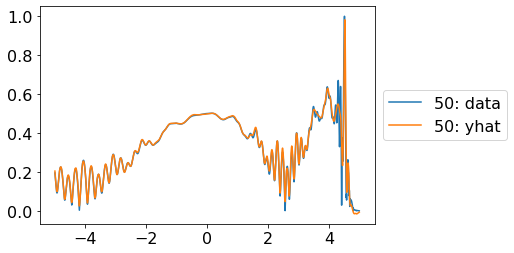

In [191]:
for k in yhats.keys():
    plt.figure()
    plt.plot(X_train[k], y_train, label=f'{k}: data')
    plt.plot(X_train[k], yhats[k], label=f'{k}: yhat')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

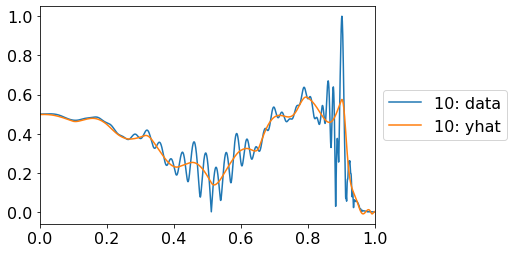

In [192]:
for i, k in enumerate(yhats.keys()):
    plt.figure()
    plt.plot(X_train[k], y_train, label=f'{k}: data')
    plt.plot(X_train[k], yhats[k], label=f'{k}: yhat')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.xlim(0.2*scales[i], 0.7*scales[i])
    plt.xlim(0., 0.1*scales[i])

In [193]:
plt.figure()
plt.plot(X_train_base, y_train, label=f'base: data')
for k in yhats.keys():
    plt.plot(X_train_base, yhats[k], label=f'{k}: yhat')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

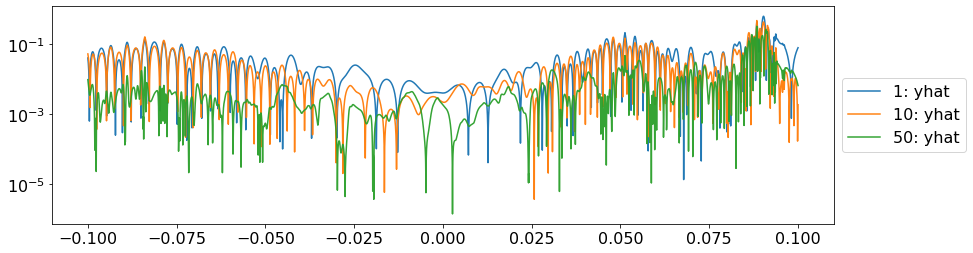

In [194]:
plt.figure(figsize=(14,4))
for i, k in enumerate(yhats.keys()):
    plt.plot(X_train_base, np.abs(y_train-yhats[k]), label=f'{k}: yhat', alpha=0.99*(i+1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')

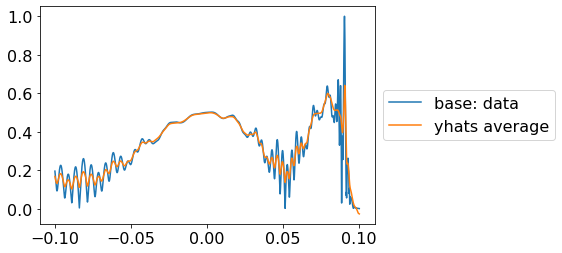

In [195]:
y_hat_final=[]

plt.figure()
plt.plot(X_train_base, y_train, label=f'base: data')
for k in yhats.keys():
    y_hat_final.append(yhats[k][:,0])
    
y_hat_final = np.asarray(y_hat_final).sum(axis=0)/len(scales)
plt.plot(X_train_base, y_hat_final, label=f'yhats average')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(-0.2, 0.)

In [196]:
y_hat_final=[]

plt.figure()
plt.plot(X_train_base, y_train, label=f'base: data')
for k in yhats.keys():
    y_hat_final.append(yhats[k][:,0])
    
y_hat_final = np.asarray(y_hat_final).sum(axis=0)/len(scales)
plt.plot(X_train_base, y_hat_final, label=f'yhats average')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0, 0.1)

(0.0, 0.1)